# Time Series - Unique Active Users 

## Project problem

A web-based application, is used by University's staff members, students and  agencies. At the moment there we keep track on How many active users are connected every month, but there is no forecasting model in place to predict active users in the following weeks. 

**Goal:** The intention of this notebook is to, using time series, create a model that can predict the active users in the following week.

**Impact:** Since the web application is deployed in the cloud, being able to predict active users, could have an impact in how effectively cloud services are provisioned and adjusted to the demand. It could potentially save some money for the company. 

**Hypothesis:** Based on University placements created, a seasonality component and the number of active users in the previous period, we could predict a higher or lower number of active users.

## Dataset

The dataset is a set of **IIS logs** from a client in Canberra **from 2017-12-07 to 2018-10-10**.

Variable | Description | type of variable 
---|---|---
 date          | Date of the event logged|continuous
 time          | Time of the event logged|continuous
 server-ip     | IP of the server|categorical
 cs-uri-query  | Part of the URL access by the client|categorical
 server-port   | Server port used for serving the page|categorical
 cs-username   | Client user. High percentage of requests are missing the user|categorical 
 client-ip     | IP of the client|categorical
 cs(User-Agent)| Http response part with information about the browser used and the type of device|categorical
 cs(Referer)   | Http reponse part with the URL accessed |categorical
 sc-status     | Http response status|categorical
 sc-substatus  | Http response sub-status|categorical
 time-taken(ms)| time taken in ms, to repond|continuous
 client-city   | City from which the client connected. Derived from the IP|categorical
 client-country| Country from which the client.Derived from the IP |categorical
 client-device | Type of deviced used to access the website by the client (Desktop or Mobile). |categorical
 client-browser| Browser used to access the website by the client. Derived from cs(User-Agent)|categorical
 client-webPage| Web page accessed by the client, Derived from cs(User-Agent)|categorical
 
 **Need to include Placements with students, placement with no students , agreggate per week - also include data related to users if possible, to predict based on type of user, agency, staff, student**

## Domain Knowledge

This is a new area for me, as I have not being actively involved in the development of this product. But when asking around other collegues from work, the conclusion was that as of now, there is no existing process to forecast active users.

There are already tools in the market like google analytics , that will give you insights based on the IIS logs, but I have not seen a tool that out from the box would provide a forecast on active users from the IIS logs.

## Project concerns
**Risks:** 

1) cs-username is missing in a lot of the observations. It might not be good enough to identify what type of user is connection to the website (staff, agency, student). If that is the case, we will just forecast active users as a whole.

2) The features and the model having a very low accuracy, below 60%. 


## Outcomes
For the project to be a success , the prediction accuraty should be at least 60%. If the project fail, I will try other features or timeseries models , with the goal to improve the accuracy to at least 60%.

## EDA

For the EDA, since we have one file for each day, the intention is to load all the files into a dataframe, enhance the data and aggregate it per week.To keep the notebook as tidy as possible, most logic to automate this process has been moved to a python class called **myLogReader.py**.

Below is a summary of the automated steps:

- List every log file in the local folder
- For each file:
    - Load the file in a df
    - Enhance df, deriving city, country, device type, browser used, weekday, etc...
    - **Default NaN** values for city, user name, webpage to **Unknown**
    - For every week (7 log files) loaded, aggregate the data and calculate number of distinct connections, total number of connections, reponse time taken (ms), number of distinct user names, etc...
    
![title](../data/img/Aggregated_data.JPG)


## 1- Load python libraries

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geoip2.database
import myLogReader as mlr
import re
import os
import sys
import datetime as dt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

%matplotlib inline

## 2- Extract - Transform and Load log files into a data frame

##### - Enhancing log data with additional information (i.e. GEO location of the IP)
##### - Aggregating log data at the week level

In [3]:
logsPath = '../data/logs'
geoLiteIPDBPath = '../data/GeoLite2-City_20181009/GeoLite2-City.mmdb'

#Create a myLogReader object
myLogReader = mlr.log()
#Open Reader
myLogReader.openReader(geoLiteIPDBPath)

In [ ]:
for i in range(1,304):
    print ('AggregatedData_week_%d.csv' % i)
    df =  myLogReader.readLogs(logsPath,7)
    df.to_csv('../data/AggregatedData_week_%d.csv' % i)

In [4]:
#Close Reader
myLogReader.closeReader()

In [ ]:
df.head()

#### Load PlacementSummary and Logs Data aggregated per week

In [31]:
log_aggregated_per_week_df = pd.read_csv('../data/LogsAggregatedData_per_week.csv')
log_aggregated_per_week_df.set_index('calendar-year-week',inplace=True)

In [32]:
log_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,Season,Month
calendar-year-week,,,,,,,,,,,,
2017-50,925,415,89497,52520170,38500,7784,27741,15472,80440,9057,WINTER,December
2017-51,866,386,81378,44703569,39664,6585,21274,13855,72925,8453,WINTER,December
2017-52,475,179,30843,14199684,9978,553,14279,6033,27735,3108,WINTER,December
2018-01,769,354,71528,42663674,31666,8049,19512,12301,64710,6818,WINTER,January
2018-02,920,441,90093,63904084,38238,6166,23249,22440,79099,10994,WINTER,January


In [33]:
placement_summary_df = pd.read_csv('../data/PlacementSummary.csv')
placement_summary_df.set_index('YearWeek',inplace=True)

In [34]:
placement_summary_df.head()

,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
YearWeek,,,,,
2017-50,246,48,234,238,8
2017-51,198,77,196,197,1
2017-52,116,3,115,116,0
2017-53,113,17,96,113,0
2018-01,113,4,111,113,0


#### JOIN Log data with Placement data

In [35]:
log_and_placements_aggregated_per_week_df = log_aggregated_per_week_df.join(placement_summary_df)
log_and_placements_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,Season,Month,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
calendar-year-week,,,,,,,,,,,,,,,,,
2017-50,925,415,89497,52520170,38500,7784,27741,15472,80440,9057,WINTER,December,246,48,234,238,8
2017-51,866,386,81378,44703569,39664,6585,21274,13855,72925,8453,WINTER,December,198,77,196,197,1
2017-52,475,179,30843,14199684,9978,553,14279,6033,27735,3108,WINTER,December,116,3,115,116,0
2018-01,769,354,71528,42663674,31666,8049,19512,12301,64710,6818,WINTER,January,113,4,111,113,0
2018-02,920,441,90093,63904084,38238,6166,23249,22440,79099,10994,WINTER,January,159,7,159,159,0


In [39]:
log_and_placements_aggregated_per_week_df.isna().sum()

client-ip-unique-count               0
cs-username-unique-count             0
client-connections-count             0
time-taken(ms)-sum                   0
Chrome-count                         0
Firefox-count                        0
Other-count                          0
Safari-count                         0
Desktop-count                        0
Mobile-count                         0
Season                               0
Month                                0
PlacementCount                       0
PlacementCompletedCount              0
PlacementAllocatedInProgressCount    0
PlacementAllocatedCount              0
PlacementNotAllocatedCount           0
dtype: int64

In [40]:
log_and_placements_aggregated_per_week_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 2017-50 to 2018-40
Data columns (total 17 columns):
client-ip-unique-count               43 non-null int64
cs-username-unique-count             43 non-null int64
client-connections-count             43 non-null int64
time-taken(ms)-sum                   43 non-null int64
Chrome-count                         43 non-null int64
Firefox-count                        43 non-null int64
Other-count                          43 non-null int64
Safari-count                         43 non-null int64
Desktop-count                        43 non-null int64
Mobile-count                         43 non-null int64
Season                               43 non-null object
Month                                43 non-null object
PlacementCount                       43 non-null int64
PlacementCompletedCount              43 non-null int64
PlacementAllocatedInProgressCount    43 non-null int64
PlacementAllocatedCount              43 non-null int64
Placement

#### Visualize target and features data

In [41]:
fig_size= plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 22
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

print ("Current size:",fig_size)


Current size: [22, 7]


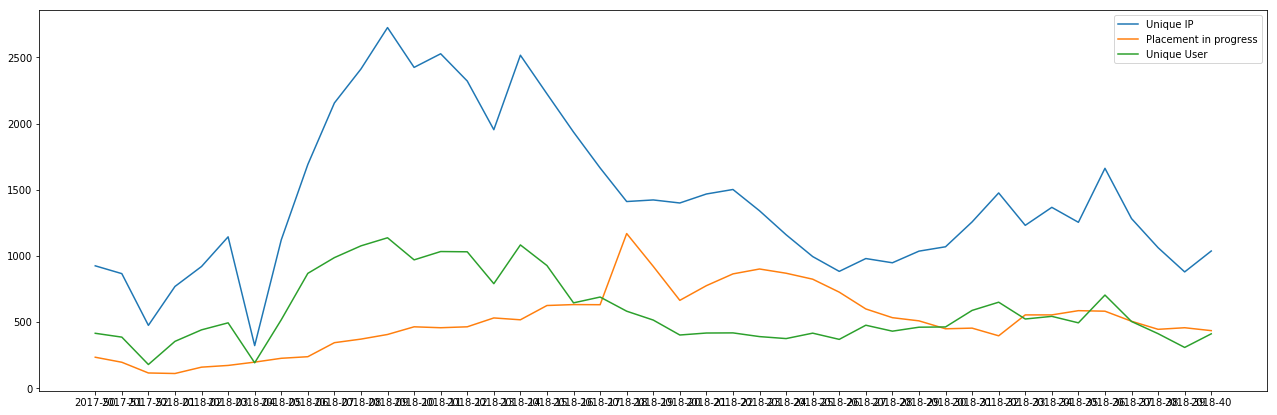

In [42]:
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['client-ip-unique-count'],label="Unique IP")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['PlacementAllocatedInProgressCount'],label="Placement in progress")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['cs-username-unique-count'],label="Unique User")
plt.legend()

The above plot shows what we could also see in the pairplot, the correlation between Unique IP count and Unique User Count, as it was expected

In [43]:
log_and_placements_aggregated_per_week_df.columns

Index(['client-ip-unique-count', 'cs-username-unique-count',
       'client-connections-count', 'time-taken(ms)-sum', 'Chrome-count',
       'Firefox-count', 'Other-count', 'Safari-count', 'Desktop-count',
       'Mobile-count', 'Season', 'Month', 'PlacementCount',
       'PlacementCompletedCount', 'PlacementAllocatedInProgressCount',
       'PlacementAllocatedCount', 'PlacementNotAllocatedCount'],
      dtype='object')

### 2.A The below pairplot shows that the distribution of the target ( client-ip_unique_count) is right skewed , it might be a good idea to take the log of the target , in order to get a normal distribution of the target.

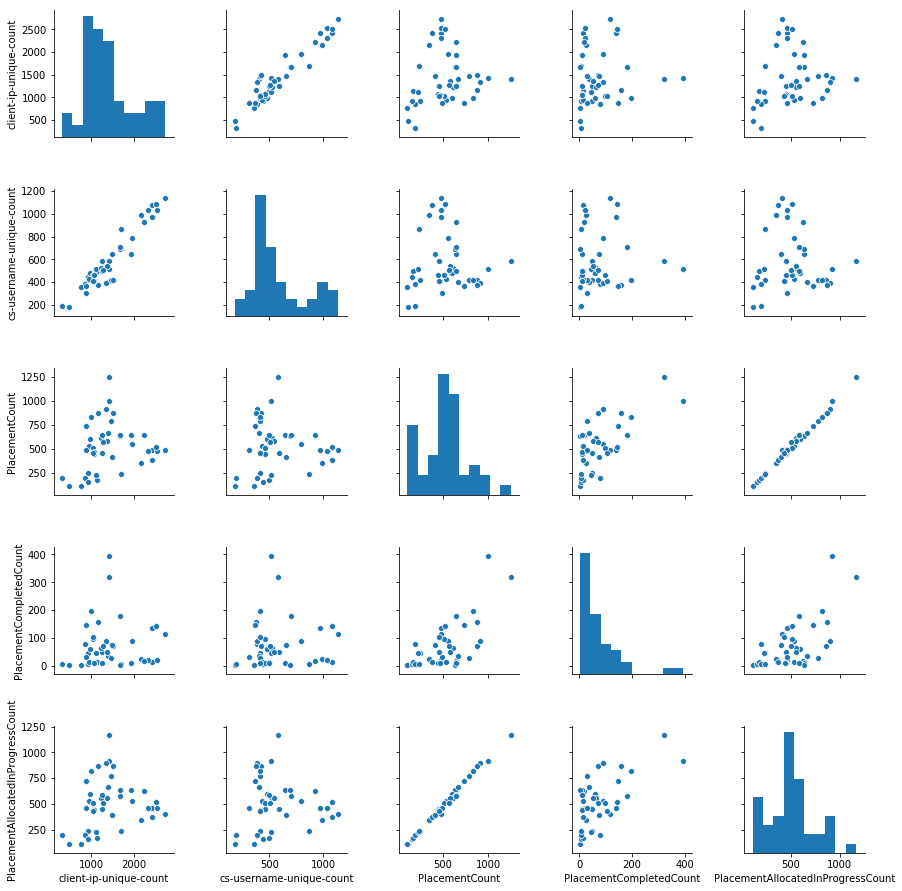

In [44]:
sns.pairplot(data=log_and_placements_aggregated_per_week_df
             ,vars=['client-ip-unique-count','cs-username-unique-count',
                    'PlacementCount', 'PlacementCompletedCount',
                    'PlacementAllocatedInProgressCount'])

### 2.B Take the Log of unique IP count

In [45]:
log_and_placements_aggregated_per_week_df["client-ip-unique-count-log"] = np.log(log_and_placements_aggregated_per_week_df["client-ip-unique-count"])

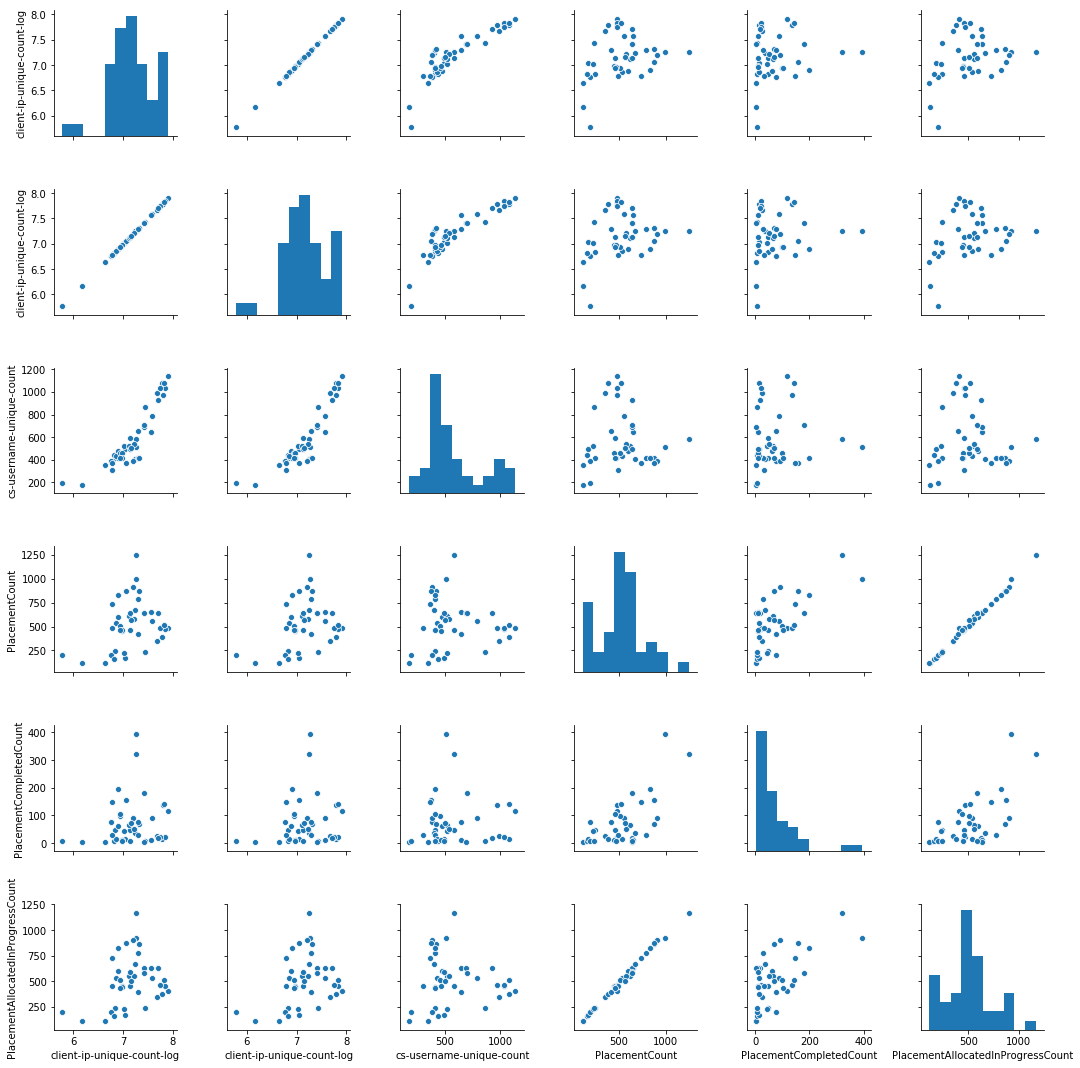

In [46]:
sns.pairplot(data=log_and_placements_aggregated_per_week_df
             ,vars=['client-ip-unique-count-log','client-ip-unique-count-log','cs-username-unique-count',
                    'PlacementCount', 'PlacementCompletedCount',
                    'PlacementAllocatedInProgressCount'])

In [47]:
log_and_placements_aggregated_per_week_df.reset_index(inplace=True)
log_and_placements_aggregated_per_week_df.head()

,calendar-year-week,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,Season,Month,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount,client-ip-unique-count-log
0,2017-50,925,415,89497,52520170,38500,7784,27741,15472,80440,9057,WINTER,December,246,48,234,238,8,6.829794
1,2017-51,866,386,81378,44703569,39664,6585,21274,13855,72925,8453,WINTER,December,198,77,196,197,1,6.763885
2,2017-52,475,179,30843,14199684,9978,553,14279,6033,27735,3108,WINTER,December,116,3,115,116,0,6.163315
3,2018-01,769,354,71528,42663674,31666,8049,19512,12301,64710,6818,WINTER,January,113,4,111,113,0,6.645091
4,2018-02,920,441,90093,63904084,38238,6166,23249,22440,79099,10994,WINTER,January,159,7,159,159,0,6.824374


## 3- Get an avarage for the period as a baseline to measure success of our model

In [48]:
log_and_placements_aggregated_per_week_df["client-ip-unique-count-MEAN"] =log_and_placements_aggregated_per_week_df["client-ip-unique-count"].mean()


log_and_placements_aggregated_per_week_df["AE"]=np.abs(
    log_and_placements_aggregated_per_week_df["client-ip-unique-count"]- 
    log_and_placements_aggregated_per_week_df["client-ip-unique-count-MEAN"]
)

log_and_placements_aggregated_per_week_df.AE.mean()

459.7836668469445

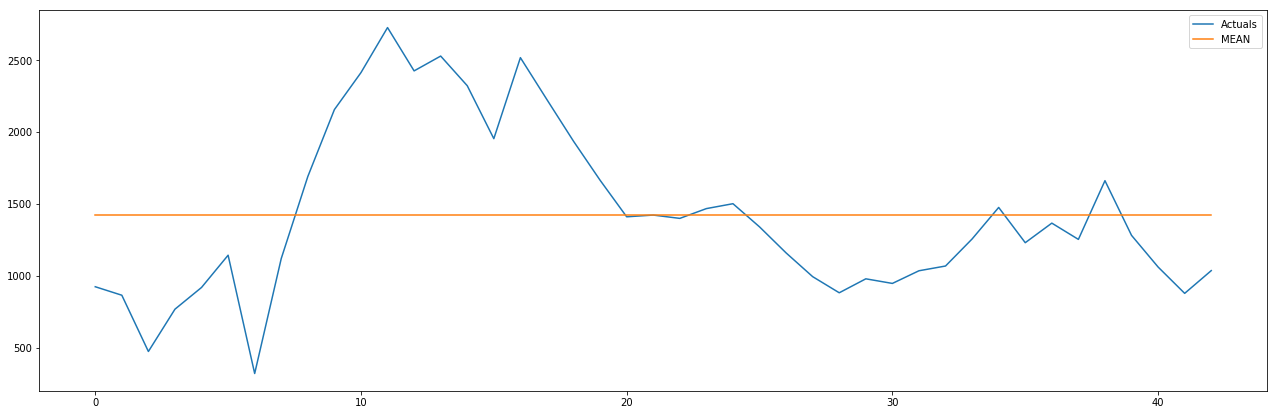

In [49]:
plt.plot(log_and_placements_aggregated_per_week_df.index, log_and_placements_aggregated_per_week_df["client-ip-unique-count"], label='Actuals')
plt.plot(log_and_placements_aggregated_per_week_df.index, log_and_placements_aggregated_per_week_df["client-ip-unique-count-MEAN"], label='MEAN')
plt.legend(loc='best')

## 4- Train/Test Split , model fit and prediction

### 4.A Training Model 1 -- Client-ip-unique-count

In [50]:
df_train = log_and_placements_aggregated_per_week_df.loc[:39,['client-ip-unique-count']]
df_test= log_and_placements_aggregated_per_week_df.loc[40:,['client-ip-unique-count']]

### Autocorreatlion

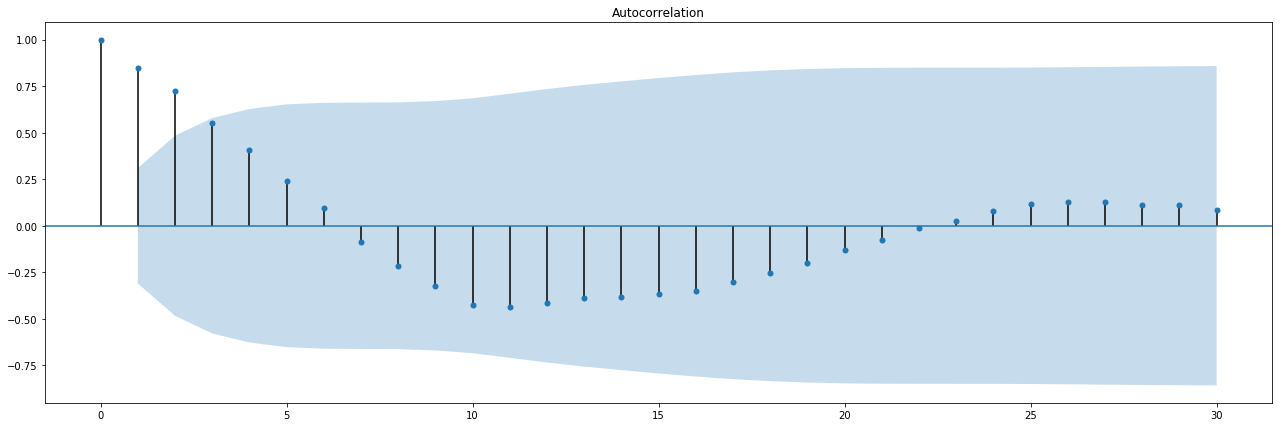

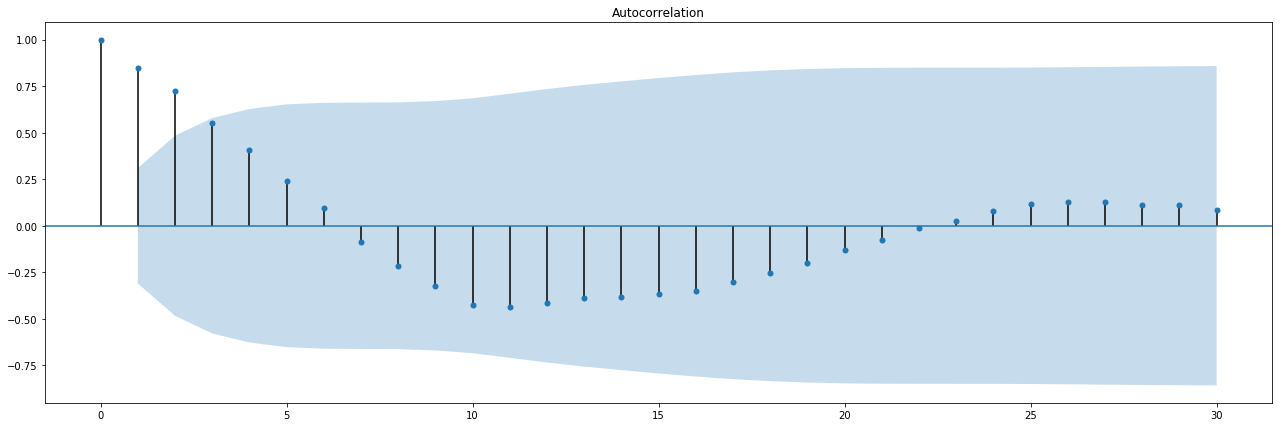

In [28]:
plot_acf(df_train,lags=30)

### ARIMA grid search

In [32]:
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train = X.loc[:39,['client-ip-unique-count']]
    test= X.loc[40:,['client-ip-unique-count']]
    
    history = [x for x in train]
    # make predictions
    predictions = list()
    model = sm.tsa.ARIMA(train, order=arima_order).fit()
    predictions = model.predict(40,42,dynamic=True)
    error = mean_absolute_error(test, predictions)
    return error


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mae = evaluate_arima_model(dataset, order)
                    if mae < best_score:
                        best_score, best_cfg = mae, order
                    print('ARIMA%s MAE=%.3f' % (order,mae))
                except:
                    continue
    print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))
 

# load dataset
p_values = [0, 1, 2, 4,6,8,10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(log_and_placements_aggregated_per_week_df.loc[:,['client-ip-unique-count']], p_values, d_values, q_values)

ARIMA(0, 0, 0) MAE=463.458
ARIMA(0, 0, 1) MAE=361.915
ARIMA(0, 0, 2) MAE=349.446
ARIMA(0, 1, 0) MAE=983.513
ARIMA(0, 1, 1) MAE=973.083
ARIMA(0, 1, 2) MAE=972.908
ARIMA(0, 2, 0) MAE=1001.114
ARIMA(0, 2, 1) MAE=880.950
ARIMA(1, 0, 0) MAE=316.066
ARIMA(1, 0, 1) MAE=320.206
ARIMA(1, 0, 2) MAE=342.539
ARIMA(1, 1, 0) MAE=971.403
ARIMA(1, 2, 0) MAE=870.283
ARIMA(1, 2, 1) MAE=880.649
ARIMA(1, 2, 2) MAE=886.008
ARIMA(2, 0, 0) MAE=321.931
ARIMA(2, 0, 1) MAE=482.269
ARIMA(2, 0, 2) MAE=622.980
ARIMA(2, 1, 0) MAE=970.594
ARIMA(2, 1, 2) MAE=946.389
ARIMA(2, 2, 0) MAE=891.864
ARIMA(2, 2, 1) MAE=875.414
ARIMA(2, 2, 2) MAE=886.837
ARIMA(4, 0, 0) MAE=362.405
ARIMA(4, 1, 0) MAE=956.703
ARIMA(4, 1, 1) MAE=953.462
ARIMA(4, 2, 0) MAE=845.026
ARIMA(4, 2, 1) MAE=854.886
ARIMA(4, 2, 2) MAE=879.589
ARIMA(6, 0, 0) MAE=405.519
ARIMA(6, 1, 0) MAE=953.673
ARIMA(6, 1, 1) MAE=953.920
ARIMA(6, 2, 0) MAE=836.046
ARIMA(6, 2, 1) MAE=853.111
ARIMA(6, 2, 2) MAE=847.051
ARIMA(8, 0, 0) MAE=476.395
ARIMA(8, 1, 0) MAE=963.731


In [36]:
df_test.tail()

,client-ip-unique-count
40,1062
41,879
42,1037


In [53]:
model = sm.tsa.ARIMA(df_train,(1,0,0)).fit()

predictions = model.predict(40,42,dynamic=True)

predictions

40    1296.814730
41    1309.370824
42    1320.012632
dtype: float64

In [54]:
print("Mean absolute error: ", mean_absolute_error(df_test, predictions))
model.summary()

Mean absolute error:  316.0660620981716


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     client-ip-unique-count   No. Observations:                   40
Model:                         ARMA(1, 0)   Log Likelihood                -285.609
Method:                           css-mle   S.D. of innovations            300.499
Date:                    Sun, 18 Nov 2018   AIC                            577.218
Time:                            22:09:07   BIC                            582.284
Sample:                                 0   HQIC                           579.050
                                                                                  
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         1379.1720    278.000      4.961      0.000     834.303    1924.041
ar.L1.client-ip-unique-count     0.8475      0.077     11.049      0.000       0.697       0.998
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1799           +0.0000j            1.1799            0.0000
-----------------------------------------------------------------------------
"""

### 4.B Training Model 2 -- Client-unique-ip-count-log

In [47]:
df_train_log = log_and_placements_aggregated_per_week_df.loc[:39,['client-ip-unique-count-log']]
df_test_log= log_and_placements_aggregated_per_week_df.loc[40:,['client-ip-unique-count-log']]

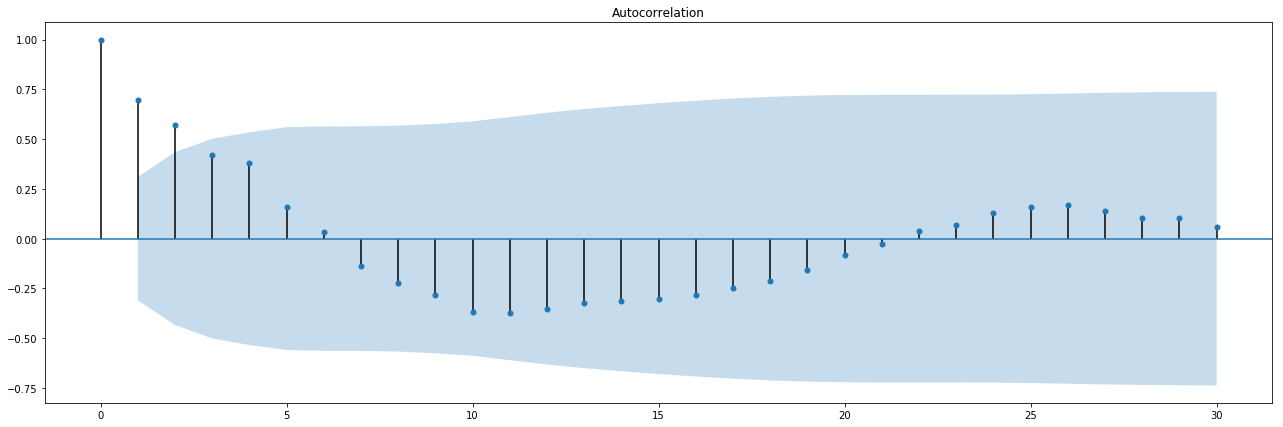

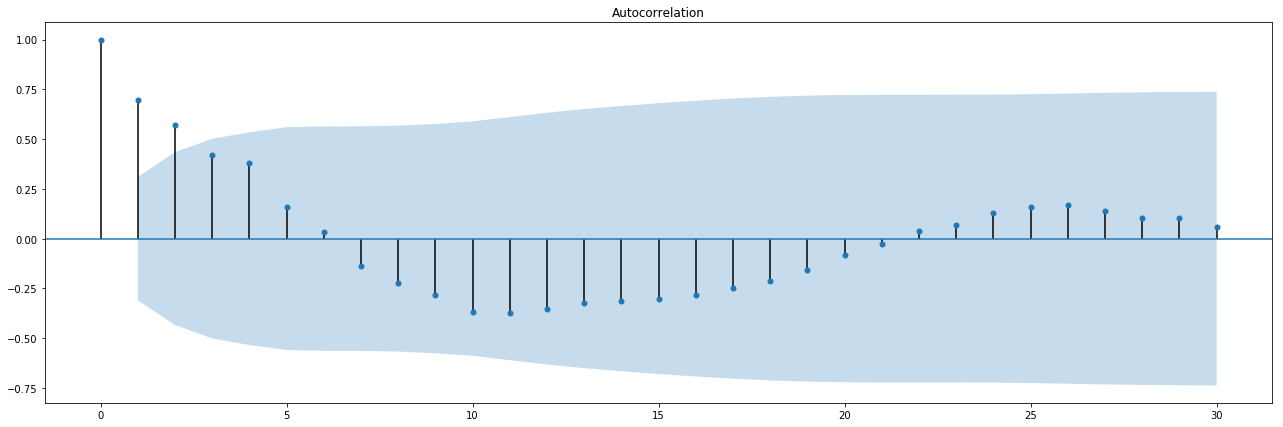

In [40]:
plot_acf(df_train_log,lags=30)

### ARIMA Grid Search

In [41]:
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train = X.loc[:39,['client-ip-unique-count-log']]
    test= X.loc[40:,['client-ip-unique-count-log']]
    
    history = [x for x in train]
    # make predictions
    predictions = list()
    model = sm.tsa.ARIMA(train, order=arima_order).fit()
    predictions = model.predict(40,42,dynamic=True)
    error = mean_absolute_error(np.exp(test), np.exp(predictions))
    return error


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mae = evaluate_arima_model(dataset, order)
                    if mae < best_score:
                        best_score, best_cfg = mae, order
                    print('ARIMA%s MAE=%.3f' % (order,mae))
                except:
                    continue
    print('Best ARIMA%s MAE=%.3f' % (best_cfg, best_score))
 

# load dataset
p_values = [0, 1, 2, 4,6,8,10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(log_and_placements_aggregated_per_week_df.loc[:,['client-ip-unique-count-log']], p_values, d_values, q_values)

ARIMA(0, 0, 0) MAE=339.950
ARIMA(0, 0, 1) MAE=300.477
ARIMA(0, 0, 2) MAE=296.603
ARIMA(0, 1, 0) MAE=991.658
ARIMA(0, 1, 1) MAE=991.630
ARIMA(0, 1, 2) MAE=991.631
ARIMA(0, 2, 0) MAE=991.672
ARIMA(0, 2, 1) MAE=991.577
ARIMA(1, 0, 0) MAE=301.267
ARIMA(1, 0, 1) MAE=330.647
ARIMA(1, 0, 2) MAE=336.184
ARIMA(1, 1, 0) MAE=991.633
ARIMA(1, 1, 1) MAE=991.631
ARIMA(1, 2, 0) MAE=991.541
ARIMA(1, 2, 1) MAE=991.565
ARIMA(2, 0, 0) MAE=337.317
ARIMA(2, 0, 1) MAE=335.832
ARIMA(2, 1, 0) MAE=991.633
ARIMA(2, 1, 1) MAE=991.631
ARIMA(2, 1, 2) MAE=991.630
ARIMA(2, 2, 0) MAE=991.573
ARIMA(2, 2, 1) MAE=991.577
ARIMA(4, 0, 0) MAE=332.853
ARIMA(4, 0, 1) MAE=339.152
ARIMA(4, 0, 2) MAE=364.582
ARIMA(4, 1, 0) MAE=991.603
ARIMA(4, 1, 1) MAE=991.603
ARIMA(4, 1, 2) MAE=991.641
ARIMA(4, 2, 0) MAE=991.519
ARIMA(4, 2, 1) MAE=991.529
ARIMA(6, 0, 0) MAE=392.584
ARIMA(6, 0, 1) MAE=414.483
ARIMA(6, 1, 0) MAE=991.603
ARIMA(6, 1, 1) MAE=991.590
ARIMA(6, 1, 2) MAE=991.600
ARIMA(6, 2, 0) MAE=991.519
ARIMA(6, 2, 1) MAE=991.543
A

In [42]:
df_test_log.tail()

,client-ip-unique-count-log
40,6.967909
41,6.778785
42,6.944087


In [49]:
model = sm.tsa.ARIMA(df_train_log,(0,0,2)).fit()
predictions_log = model.predict(40,42,dynamic=True)
predictions_log

40    7.170501
41    7.126363
42    7.187635
dtype: float64

In [50]:
print("Mean absolute error: ", mean_absolute_error(df_test_log, predictions_log))
model.summary()

Mean absolute error:  0.26457248443563647


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                  
======================================================================================
Dep. Variable:     client-ip-unique-count-log   No. Observations:                   40
Model:                             ARMA(0, 2)   Log Likelihood                 -12.528
Method:                               css-mle   S.D. of innovations              0.329
Date:                        Sun, 18 Nov 2018   AIC                             33.056
Time:                                22:08:35   BIC                             39.811
Sample:                                     0   HQIC                            35.498
                                                                                      
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                7.1876      0.104     68.994      0.000       6.983       7.392
ma.L1.client-ip-unique-count-log     0.6540      0.162      4.043      0.000       0.337       0.971
ma.L2.client-ip-unique-count-log     0.3846      0.119      3.228      0.003       0.151       0.618
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.8503           -1.3701j            1.6125           -0.3384
MA.2           -0.8503           +1.3701j            1.6125            0.3384
-----------------------------------------------------------------------------
"""

### 4.C Holt-Winters

##### Interestingly enough, there is a massive improvement in the model when we change the size of the train and test data, from ** 4 observations ** in the test data to ** 11 obsevations**.

In [92]:
train1, test1 = log_and_placements_aggregated_per_week_df.iloc[:39,1], log_and_placements_aggregated_per_week_df.iloc[39:,1]


model1 = ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=12).fit()
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])


mean_absolute_error(test1, pred1)

733.074075580087

In [93]:
train2, test2 = log_and_placements_aggregated_per_week_df.iloc[:31,1], log_and_placements_aggregated_per_week_df.iloc[31:,1]


model2 = ExponentialSmoothing(train2, seasonal='mul', seasonal_periods=12).fit()
pred2 = model2.predict(start=test2.index[0], end=test2.index[-1])


mean_absolute_error(test2, pred2)

185.07972044767533

## 5- Plot results



### 5.A ARIMA results

Applying exp to the train, test and prediction data, to plot actual values, since data used to fit the model had the log applied to the target.

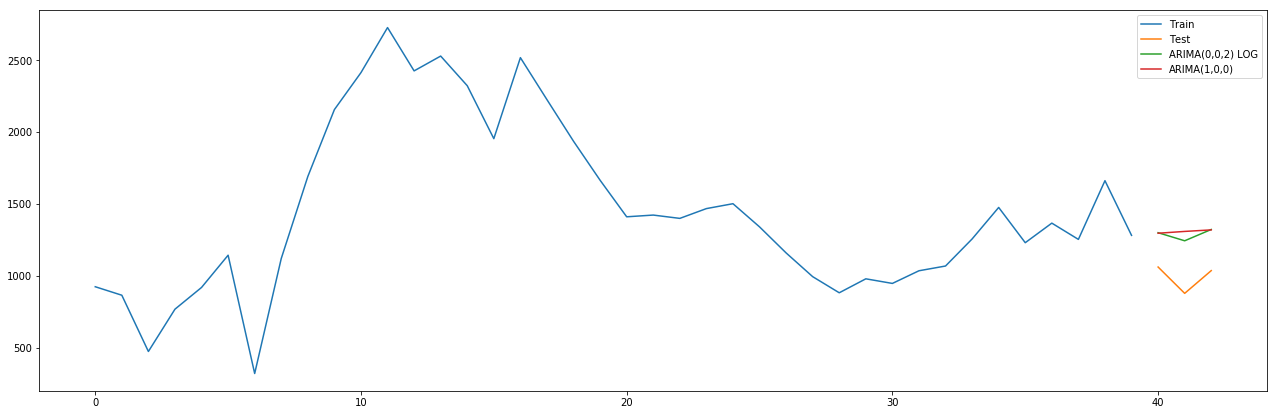

In [55]:
plt.plot(df_train_log.index, np.exp(df_train_log), label='Train')
plt.plot(df_test_log.index, np.exp(df_test_log), label='Test')
plt.plot(predictions_log.index, np.exp(predictions_log), label='ARIMA(0,0,2) LOG')
plt.plot(predictions.index, predictions, label='ARIMA(1,0,0)')
plt.legend(loc='best')

### 5.B Holt-Winters results

Trying out Holt-Winter's model. Interestingly, when spliting train, test data, the model performs bettwer when giving more training data and less test data.

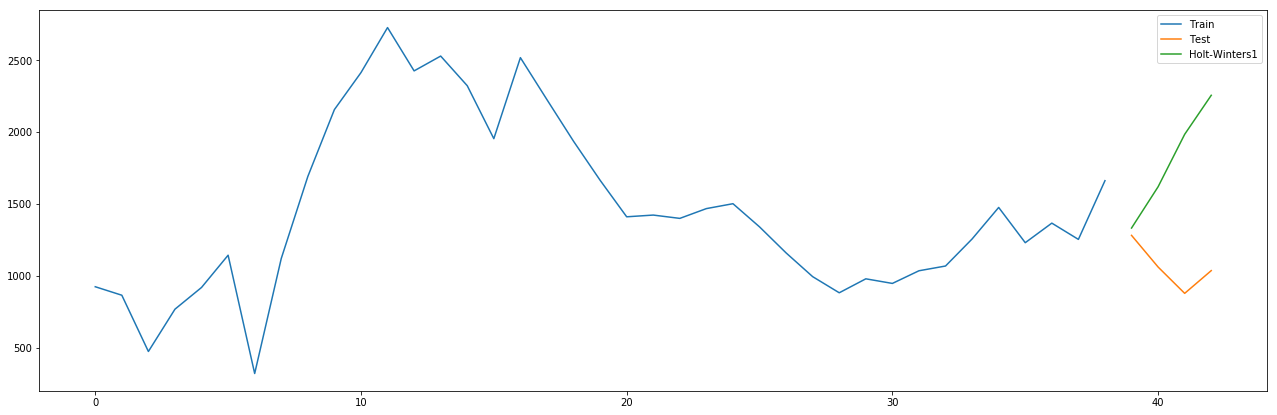

In [53]:
plt.plot(train1.index, train1, label='Train')
plt.plot(test1.index, test1, label='Test')
plt.plot(pred1.index, pred1, label='Holt-Winters1')
plt.legend(loc='best')


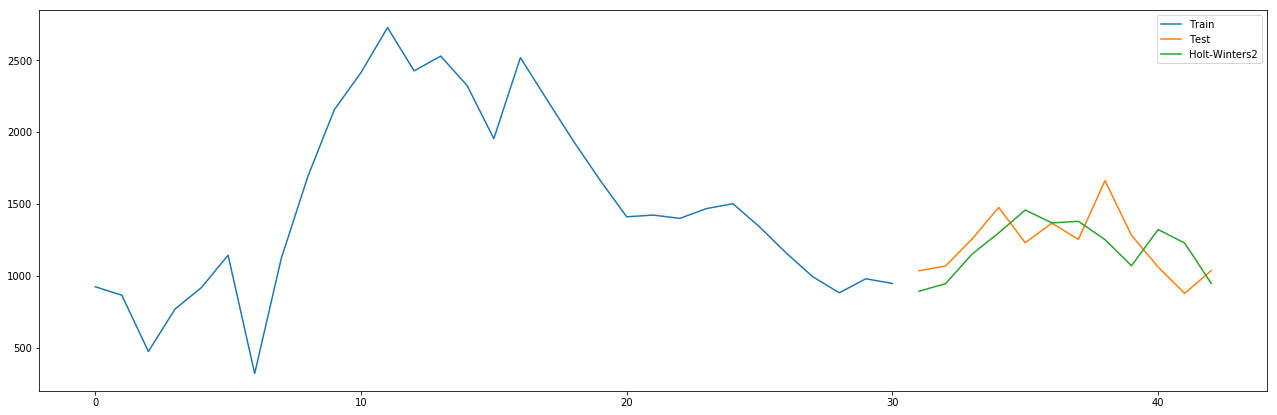

In [54]:
plt.plot(train2.index, train2, label='Train')
plt.plot(test2.index, test2, label='Test')
plt.plot(pred2.index, pred2, label='Holt-Winters2')
plt.legend(loc='best')


## 6- Repeat EDA for dataset aggregated by day

**Try prediction per day**

In [55]:
df_per_day = pd.read_csv("../data/log_data_per_day.csv")

df_per_day = df_per_day.sort_values("date").reset_index()

df_per_day.drop(columns=["Unnamed: 0","index"],axis=1,inplace=True)

df_per_day.head()

,date,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count
0,2017-12-11,265,145,22338,12255723.0,9851,2889,6421,3177,20677,1661
1,2017-12-12,233,132,19352,9666209.0,8983,1881,5523,2965,17707,1645
2,2017-12-13,267,161,19988,14207636.0,9871,1133,4843,4141,17275,2713
3,2017-12-14,202,97,12630,9258349.0,4978,809,4440,2403,11034,1596
4,2017-12-15,180,82,10433,5169290.0,3805,1059,3583,1986,9413,1020


### 6.A Plot avarage of Unique client IP accross the entire dataset period

In [56]:
df_per_day["client-ip-unique-count-MEAN"] =df_per_day["client-ip-unique-count"].mean()


df_per_day["AE"]=np.abs(
    df_per_day["client-ip-unique-count"]- 
    df_per_day["client-ip-unique-count-MEAN"]
)

print("Mean Absolute Error: ",df_per_day.AE.mean())

Mean Absolute Error:  123.66127503839469


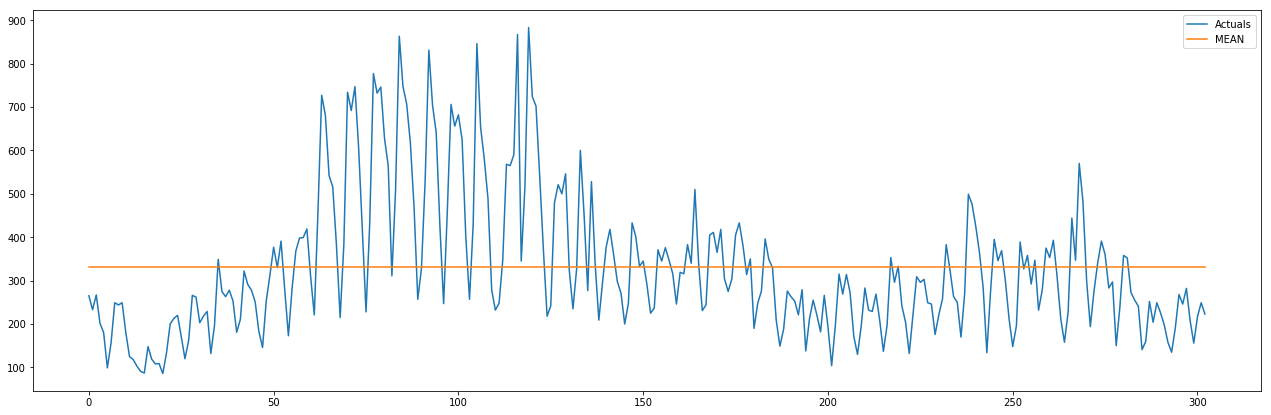

In [57]:
plt.plot(df_per_day.index, df_per_day["client-ip-unique-count"], label='Actuals')
plt.plot(df_per_day.index, df_per_day["client-ip-unique-count-MEAN"], label='MEAN')
plt.legend(loc='best')

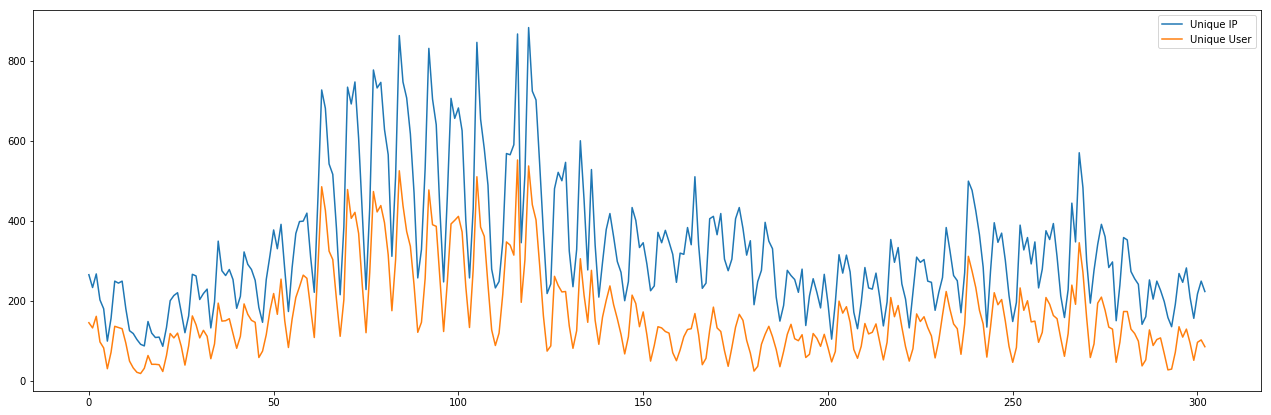

In [58]:
plt.plot(df_per_day.index,df_per_day['client-ip-unique-count'],label="Unique IP")
plt.plot(df_per_day.index,df_per_day['cs-username-unique-count'],label="Unique User")
plt.legend()

### 6.B ARIMA (1,0,4) best results

In [59]:
df_per_day_train = df_per_day.loc[:299,['client-ip-unique-count']]
df_per_day_test= df_per_day.loc[300:,['client-ip-unique-count']]

In [60]:
model = sm.tsa.ARIMA(df_per_day_train,(1,0,4)).fit()

predictions = model.predict(300,302,dynamic=True)

predictions

300    193.650257
301    228.749887
302    229.762578
dtype: float64

In [61]:
df_per_day_test.head()

,client-ip-unique-count
300,217
301,249
302,223


In [62]:
print("Mean absolute error: ", mean_absolute_error(df_per_day_test, predictions))
model.summary()

Mean absolute error:  16.787478000778


<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARMA Model Results                                
==================================================================================
Dep. Variable:     client-ip-unique-count   No. Observations:                  300
Model:                         ARMA(1, 4)   Log Likelihood               -1805.252
Method:                           css-mle   S.D. of innovations             99.078
Date:                    Mon, 19 Nov 2018   AIC                           3624.505
Time:                            14:11:25   BIC                           3650.431
Sample:                                 0   HQIC                          3634.881
                                                                                  
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          297.0649     70.253      4.229      0.000     159.372     434.757
ar.L1.client-ip-unique-count     0.9852      0.011     93.055      0.000       0.964       1.006
ma.L1.client-ip-unique-count    -0.2135      0.076     -2.796      0.006      -0.363      -0.064
ma.L2.client-ip-unique-count    -0.5253      0.083     -6.308      0.000      -0.689      -0.362
ma.L3.client-ip-unique-count    -0.1204      0.060     -2.006      0.046      -0.238      -0.003
ma.L4.client-ip-unique-count     0.0660      0.105      0.630      0.529      -0.139       0.271
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0150           +0.0000j            1.0150            0.0000
MA.1            1.1447           -0.0000j            1.1447           -0.0000
MA.2           -1.5831           -0.9669j            1.8550           -0.4127
MA.3           -1.5831           +0.9669j            1.8550            0.4127
MA.4            3.8465           -0.0000j            3.8465           -0.0000
-----------------------------------------------------------------------------
"""

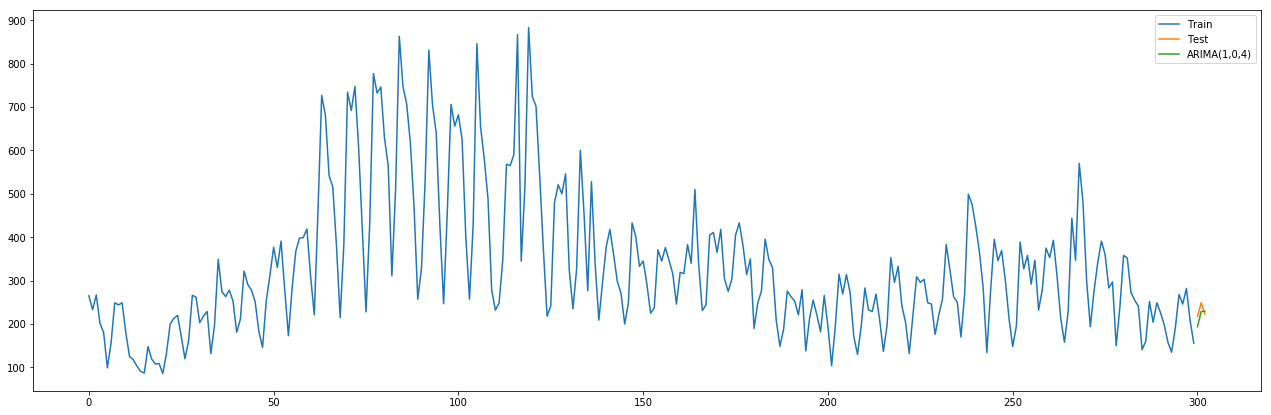

In [16]:
plt.plot(df_per_day_train.index, df_per_day_train, label='Train')
plt.plot(df_per_day_test.index, df_per_day_test, label='Test')
plt.plot(predictions.index, predictions, label='ARIMA(1,0,4)')
plt.legend(loc='best')

### 6.C Holt-Winter

In [63]:
df_per_day_train1, df_per_day_test1 = df_per_day.iloc[:300,1], df_per_day.iloc[300:,1]


model1 = ExponentialSmoothing(df_per_day_train1, seasonal='mul', seasonal_periods=12).fit()
pred1 = model1.predict(start=df_per_day_test1.index[0], end=df_per_day_test1.index[-1])


np.sqrt(mean_squared_error(df_per_day_test1, pred1))

19.632664883649973

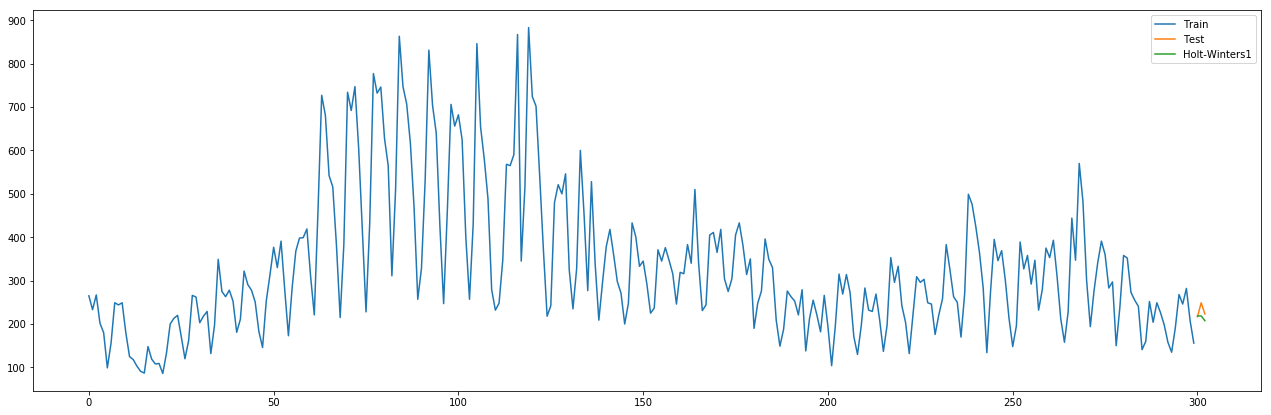

In [71]:
plt.plot(df_per_day_train1.index, df_per_day_train1, label='Train')
plt.plot(df_per_day_test1.index, df_per_day_test1, label='Test')
plt.plot(pred1.index, pred1, label='Holt-Winters1')
plt.legend(loc='best')

In [69]:
df_per_day_train2, df_per_day_test2 = df_per_day.iloc[:295,1], df_per_day.iloc[295:,1]


model2 = ExponentialSmoothing(df_per_day_train2, seasonal='mul', seasonal_periods=12).fit()
pred2 = model2.predict(start=df_per_day_test2.index[0], end=df_per_day_test2.index[-1])


np.sqrt(mean_squared_error(df_per_day_test2, pred2))

46.23178268563616

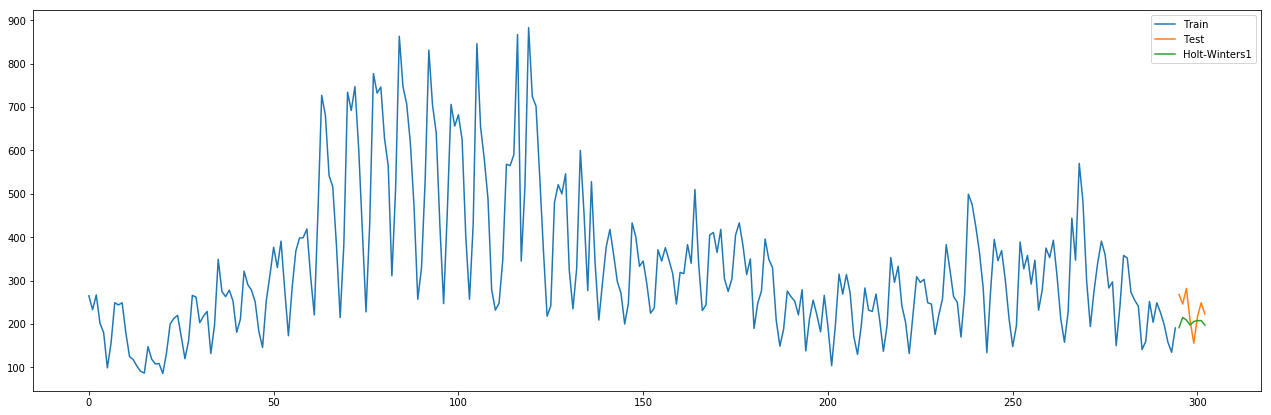

In [72]:
plt.plot(df_per_day_train2.index, df_per_day_train2, label='Train')
plt.plot(df_per_day_test2.index, df_per_day_test2, label='Test')
plt.plot(pred2.index, pred2, label='Holt-Winters1')
plt.legend(loc='best')

## 7- Compare results

Aggregate level | Model | Mean Absolute Error (MAE) | Improvement from Baseline
---|---|---|---
Weekly| Mean (baseline)| **MAE: 459.783**|
Weekly| ARIMA(1,0,0)  | MAE: 316.066|
Weekly| Log ARIMA(0,0,2) | MAE: 296.603|
Weekly| Holt-Winter - 3 observations in test df | MAE: 733.074|
Weekly| Holt-Winter - 12 observations in test df | _**MAE: 185.079**_| **148 %**
Daily| Mean (baseline)| **MAE: 123.661**|
Daily| ARIMA(1,0,4)          | _**MAE: 16.787**_| **668 %**
Daily| Holt-Winter - 8 observations in test df          | MAE: 19.632|
Daily| Holt-Winter - 3 observations in test df          | MAE: 46.231|

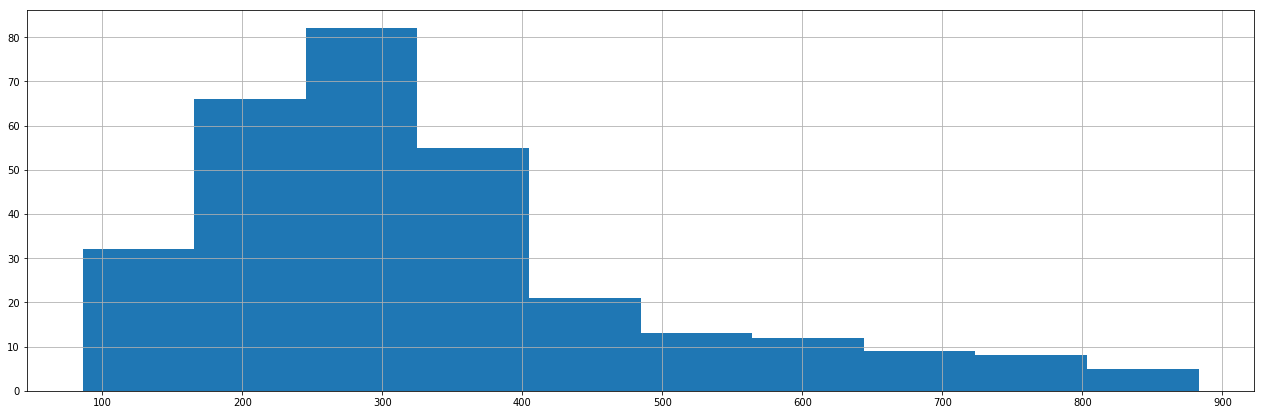

In [80]:
df_per_day["client-ip-unique-count"].hist()

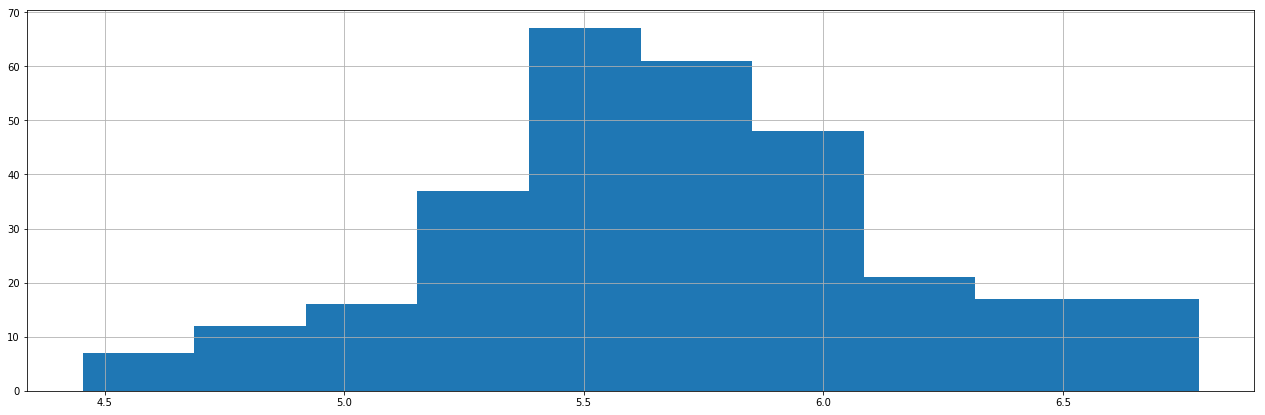

In [82]:
df_per_day["client-ip-unique-count-log"] = np.log(df_per_day["client-ip-unique-count"])
df_per_day["client-ip-unique-count-log"].hist()

In [91]:
train3, test3 = log_and_placements_aggregated_per_week_df.iloc[:39,18], log_and_placements_aggregated_per_week_df.iloc[39:,18]


model3 = ExponentialSmoothing(train3, seasonal='mul', seasonal_periods=12).fit()
pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])


(mean_absolute_error(np.exp(test3), np.exp(pred3)))

214.15302271027497

In [88]:
np.exp(0.241)

1.272521035308229